In [1]:
import tensorflow as tf
import numpy as np 
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer

In [2]:
save_model = 'D:/projects/ai/poc/homework/training_model.h5'

In [3]:

# s = pd.Series(np.random.randn(100))
# s = pd.Series(np.random.randint(low=0,high=1500,size=100))
# q = s.quantile([0, .75])  # calculate lower and upper bounds
# #np.random.randn(100)
# #q
# print(q)
# s.describe()

In [4]:
# 根据箱线图的上下限进行异常值的填充
def boxplot_fill(col):
    # 计算iqr：数据四分之三分位值与四分之一分位值的差
    iqr = col.quantile(0.75)-col.quantile(0.25)
    # 根据iqr计算异常值判断阈值
    u_th = col.quantile(0.75) + 1.5*iqr # 上界
    l_th = col.quantile(0.25) - 1.5*iqr # 下界
    # 定义转换函数：如果数字大于上界则用上界值填充，小于下界则用下界值填充。
    def box_trans(x):
        if x > u_th:
            return u_th
        elif x < l_th:
            return l_th
        else:
            return x
    return col.map(box_trans)
def iqr(df, colname, bounds = [.25, .75]):
    s = df[colname]
    q = s.quantile(bounds)
    return df[~s.clip(*q).isin(q)]
def iqrfilter(df, colname, bounds = [.25, .75]):
    s = df[colname]
    Q1 = df[colname].quantile(bounds[0])
    Q3 = df[colname].quantile(bounds[1])
    IQR = Q3 - Q1
    # no_outliers = df.col[(Q1 - 1.5*IQR < df.BMI) &  (df.BMI < Q3 + 1.5*IQR)]
    # outliers = df.col[(Q1 - 1.5*IQR >= df.BMI) |  (df.BMI >= Q3 + 1.5*IQR)]
    print(IQR,Q1,Q3,Q1 - 1.5*IQR,Q3+ 1.5 * IQR)
    if bounds[0]==0:
        return df[~s.clip(*[Q1,Q3+ 1.5 * IQR]).isin([Q1,Q3+ 1.5 * IQR])]
    else:
        return df[~s.clip(*[Q1 - 1.5*IQR,Q3+ 1.5 * IQR]).isin([Q1 - 1.5*IQR,Q3+ 1.5 * IQR])]


#df_train =iqrfilter(df_train,'CYCLE_TIME',[0.25, .75])    
    # Q1 = stepframe.quantile(0.25)
    # Q3 = stepframe.quantile(0.75)
    # IQR = Q3 - Q1

    # df = stepframe[~((stepframe < (Q1 - 1.5 * IQR)) |(stepframe > (Q3 + 1.5 * IQR))).any(axis=1)]




    
# def cap(x,quantile=[0.01,0.99]):
#     """盖帽法处理异常值
#     Args：
#         x：pd.Series列，连续变量
#         quantile：指定盖帽法的上下分位数范围
#     """

# # 生成分位数
#     Q01,Q99=x.quantile(quantile).values.tolist()

# # 替换异常值为指定的分位数
#     if Q01 > x.min():
#         x = x.copy()
#         x.loc[x<Q01] = Q01

#     if Q99 < x.max():
#         x = x.copy()
#         x.loc[x>Q99] = Q99

#     return(x) 
def MFGDate(_date):
    if _date.dt.hour < '07:30' :
       return _date.dt.time

    else:
       return _date+ pd.Timedelta(days=-1)

In [5]:
df_train = pd.read_csv('D:/projects/ai/poc/homework/training_data_20210128.csv')
# 刪除null值


# df=df.head(1000)
#df = pd.read_excel(source_file_path)
#df = pd.read_csv(source_file_path)
df_train = df_train.loc[df_train['LOT_TYPE']=='FDY']
df_train = df_train.loc[df_train['LAYER']!='XX']

df_train['CHIPNAME'] = df_train['CHIPNAME'].str.strip()
df_train = df_train.loc[df_train['CHIPNAME']=='CHIP266']          

df_train['PRIORITY'] = df_train['PRIORITY'].astype(str)
df_train['IS_MAIN_ROUTE'] = df_train['IS_MAIN_ROUTE'].astype(str)
df_train['DATA_DATE'] = df_train['DATA_DATE'].astype(str)
          
df_train['DATA_DATE'] = pd.to_datetime(df_train['DATA_DATE'], infer_datetime_format=True)
df_train['WS_DATE'] = pd.to_datetime(df_train['WS_DATE'], infer_datetime_format=True)

df_train = df_train.assign(PROCESSED_DAYS = ((df_train['DATA_DATE'] -df_train['WS_DATE'])/pd.Timedelta(1, 'D')).fillna(0).astype('float64'))
# df_train = df_train.assign(PROCESSED_DAYS = ((df_train['DATA_DATE'] -df_train['WS_DATE'])/pd.Timedelta(1, 'D')).fillna(0).astype(int))
df_train['ACTUAL_WP_OUT'] =pd.to_datetime(df_train['ACTUAL_WP_OUT'], infer_datetime_format=True)

df_train = df_train.assign(CYCLE_TIME=((df_train['ACTUAL_WP_OUT']-df_train['WS_DATE'])/pd.Timedelta(1, 'D')).fillna(0).astype('float64'))
# df_train = df_train.assign(CYCLE_TIME=((df_train['ACTUAL_WP_OUT']-df_train['WS_DATE'])/pd.Timedelta(1, 'D')).fillna(0).astype(int))
df_train = df_train.assign(REMAIN_DAYS=((df_train['ACTUAL_WP_OUT']-df_train['DATA_DATE'])/pd.Timedelta(1, 'D')).fillna(0).astype('float64'))
# df_train = df_train.assign(REMAIN_DAYS=((df_train['ACTUAL_WP_OUT']-df_train['DATA_DATE'])/pd.Timedelta(1, 'D')).fillna(0).astype(int))
#計算LAYER_REMAIN_DAYS
conditions = [df_train['LAYER'].eq(layer) for layer in df_train['LAYER'].unique()]
choices = [df_train[f'{layer}'] for layer in df_train['LAYER'].unique()]
df_train['LAYER_REMAIN_DAYS'] = np.select(conditions, choices)


MemoryError: Unable to allocate 427. MiB for an array with shape (247, 226723) and data type float64

In [95]:
#print(sum(pd.isnull(df_train['REMAIN_LAYER_SEQ'])))

In [96]:
df_test = pd.read_csv('D:/projects/ai/poc/homework/testing_data_20210128.csv')

df_test = df_test.loc[df_test['LOT_TYPE']=='FDY']
df_test = df_test.loc[df_test['LAYER']!='XX']
df_test['CHIPNAME'] = df_test['CHIPNAME'].str.strip()
df_test = df_test.loc[df_test['CHIPNAME']=='CHIP266']   
     

df_test['PRIORITY'] = df_test['PRIORITY'].astype(str)
df_test['IS_MAIN_ROUTE'] = df_test['IS_MAIN_ROUTE'].astype(str)
df_test['DATA_DATE'] = df_test['DATA_DATE'].astype(str) 

df_test['DATA_DATE'] = pd.to_datetime(df_test['DATA_DATE'], infer_datetime_format=True)

df_test['WS_DATE'] = pd.to_datetime(df_test['WS_DATE'], infer_datetime_format=True)
df_test = df_test.assign(PROCESSED_DAYS = ((df_test['DATA_DATE'] -df_test['WS_DATE'])/pd.Timedelta(1, 'D')).fillna(0).astype('float64'))
# df_test = df_test.assign(PROCESSED_DAYS = ((df_test['DATA_DATE'] -df_test['WS_DATE'])/pd.Timedelta(1, 'D')).fillna(0).astype(int))
df_test['ACTUAL_WP_OUT'] =pd.to_datetime(df_test['ACTUAL_WP_OUT'], infer_datetime_format=True)

df_test = df_test.assign(CYCLE_TIME=((df_test['ACTUAL_WP_OUT']-df_test['WS_DATE'])/pd.Timedelta(1, 'D')).fillna(0).astype('float64'))
# df_test = df_test.assign(CYCLE_TIME=((df_test['ACTUAL_WP_OUT']-df_test['WS_DATE'])/pd.Timedelta(1, 'D')).fillna(0).astype(int))

df_test = df_test.assign(REMAIN_DAYS=((df_test['ACTUAL_WP_OUT']-df_test['DATA_DATE'])/pd.Timedelta(1, 'D')).fillna(0).astype('float64'))
# df_test = df_test.assign(REMAIN_DAYS=((df_test['ACTUAL_WP_OUT']-df_test['DATA_DATE'])/pd.Timedelta(1, 'D')).fillna(0).astype('int'))
#計算LAYER_REMAIN_DAYS
conditions = [df_test['LAYER'].eq(layer) for layer in df_test['LAYER'].unique()]
choices = [df_test[f'{layer}'] for layer in df_test['LAYER'].unique()]
df_test['LAYER_REMAIN_DAYS'] = np.select(conditions, choices)



In [97]:
#移除cycle time outlier
#df_train =iqr(df_train,'CYCLE_TIME',[0, .75])    
df_train =iqrfilter(df_train,'CYCLE_TIME',[0, .75])    
#df_test =iqr(df_test,'CYCLE_TIME',[0, .75])    
# print(df2_test.isnull().sum())
# print(df2_train.isnull().sum

28.84444444444445 34.49027777777778 63.334722222222226 -8.776388888888896 106.60138888888889


In [98]:
# df.fillna(0, inplace=True)
# df = df.assign(REMAIN_DAYS = ((pd.to_datetime(df['ACTUAL_WP_OUT'], format='%Y%m%d')-pd.to_datetime(df['DATA_DATE'], format='%Y%m%d'))/pd.Timedelta(1, 'D')).fillna(0).astype(int))
#df = train_df.drop(train_df.loc[:, '0E':'ZL'].columns, axis = 1)
df2_train = df_train.drop(columns=['IDX','LOT_TYPE','WS_DATE','ACTUAL_WP_OUT','DATA_DATE','OP_NO','LOT_ID'])
df2_train = df2_train.drop(df2_train.loc[:, '0E':'ZL'].columns, axis = 1) 

df2_train = df2_train.drop(columns=['CYCLE_TIME','CHIPNAME'])
#df2_train = df2_train.drop(columns=['PRIORITY'])



In [99]:

df2_test = df_test.drop(columns=['IDX','LOT_TYPE','WS_DATE','ACTUAL_WP_OUT','DATA_DATE','OP_NO','LOT_ID'])
df2_test = df2_test.drop(df2_test.loc[:, '0E':'ZL'].columns, axis = 1) 
df2_test = df2_test.drop(columns=['CYCLE_TIME','CHIPNAME'])
#df2_test = df2_test.drop(columns=['PRIORITY'])


In [100]:
#df_train.isnull().sum().sort_values(ascending = False).head()
#sum(pd.isnull(df_train['REMAIN_LAYER_SEQ']))

In [101]:
# 1. 查看缺失情况

df2_train = df2_train.dropna() # 刪除null值
df2_test = df2_test.dropna()# 刪除null值
# print(df2_test.isnull().sum())
# print(df2_train.isnull().sum())
# print(df_train.isnull().sum())
# print(df_test.isnull().sum())
 

In [102]:

# 在进行数据分析前，一般需要了解数据的缺失情况，在Python中可以构造一个lambda函数来查看缺失值，该lambda函数中，sum(col.isnull())表示当前列有多少缺失，col.size表示当前列总共多少行数据：
# df2_test.apply(lambda col:sum(col.isnull())/col.size)
# df2_train.apply(lambda col:sum(col.isnull())/col.size)

#2. 以指定值填补
#  df2_test.score.fillna(sample.score.mean()) 填补方法为均值
#  df2_test.score.fillna(sample.score.median()) 分位数等方法进行填补
#pandas数据框提供了fillna方法完成对缺失值的填补，例如对sample表的列score填补缺失值，填补方法为均值：

# df_train = df_train.dropna()
# df_test = df_test.dropna()

#03 噪声值处理 噪声值指数据中有一个或几个数值与其他数值相比差异较大，又称为异常值、离群值(outlier)。
#1. 盖帽法 盖帽法将某连续变量均值上下三倍标准差范围外的记录替换为均值上下三倍标准差值，即盖帽处理
#Python中可自定义函数完成盖帽法。如下所示，参数x表示一个pd.Series列，quantile指盖帽的范围区间，默认凡小于百分之1分位数和大于百分之99分位数的值将会被百分之1分位数和百分之99分位数替代：


In [103]:
# cap(df_train['REMAIN_DAYS'])
# df_train['REMAIN_DAYS']
# # 查看离群情况
# df_train['REMAIN_DAYS'].hist() #看長條圖
# plt.show()
# df_train[['REMAIN_DAYS']].boxplot()
# plt.show()
# # # 填充效果查看
# # boxplot_fill(df2_train['REMAIN_DAYS']).hist()
# # # 进行赋值
# # df['REMAIN_DAYS'] = boxplot_fill(df['REMAIN_DAYS'])
# # plt.show()

In [104]:
labelencoder = LabelEncoder()
# df2_train['PRIORITY'] = labelencoder.fit_transform(df2_train['PRIORITY'])
# df2_train['IS_MAIN_ROUTE'] = labelencoder.fit_transform(df2_train['IS_MAIN_ROUTE'])
# df2_train['STATUS'] = labelencoder.fit_transform(df2_train['STATUS'])
# df2_train['CHIPNAME'] = labelencoder.fit_transform(df2_train['CHIPNAME'])
# df2_train['OP_NO'] = labelencoder.fit_transform(df2_train['OP_NO'])


# for col in df2_train[['PRIORITY','IS_MAIN_ROUTE','STATUS', 'LAYER']]:
#     df2_train[col]=labelencoder.fit_transform(df2_train[col])
df2_train.info()
#==============================

#1.label Encoder 手動轉換  自己製作STATUS
# STATUS_mapping={'WAITING':0,'PROCESSING':1}
# train_df['STATUS']=train_df['STATUS'].map(STATUS_mapping)
# test_df['STATUS']=test_df['STATUS'].map(STATUS_mapping)

#2.label Encoder 自動轉換 
# category_col =['CHIPNAME', 'LAYER','LOT_TYPE'] 

# # 大部分的模型都是基於數學運算，字串無法套入數學模型進行運算，在此先對其進行Label encoding編碼，我們從 sklearn library中導入 LabelEncoder class，對第一行資料進行fit及transform並取代之
# for col in category_col:
#     train_df[col] = labelEncoder.fit_transform(train_df[col])
# for col in category_col:
#     test_df[col] = labelEncoder.fit_transform(test_df[col])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14039 entries, 2242 to 222839
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   STATUS             14039 non-null  object 
 1   LAYER              14039 non-null  object 
 2   REMAIN_LAYER_SEQ   14039 non-null  float64
 3   REMAIN_OP_SEQ      14039 non-null  float64
 4   PRIORITY           14039 non-null  object 
 5   WIP_QTY            14039 non-null  int64  
 6   IS_MAIN_ROUTE      14039 non-null  object 
 7   PROCESSED_DAYS     14039 non-null  float64
 8   REMAIN_DAYS        14039 non-null  float64
 9   LAYER_REMAIN_DAYS  14039 non-null  float64
dtypes: float64(5), int64(1), object(4)
memory usage: 1.2+ MB


In [105]:
#============================
#one hot encoder
#============================
df2_train_eh=pd.get_dummies(df2_train.drop('REMAIN_DAYS', axis=1))
X_dropped = np.asarray(df2_train_eh)
Y_dropped = np.asarray(df2_train['REMAIN_DAYS'])
# Separate labels with features  
# 將 dataframe 轉換為 array
# ndarray = df2.values  
# train_labels = ndarray[:,9]    # Labels are the values we want to predict
# train_features = ndarray[:,:9] # Remove the labels from the features

#X_test = X_test.reindex(columns = X_train.columns, fill_value=0)


In [106]:
#One hot encoding  使用Pandas進行   
# get_dummies可以直接轉字串，反而無法轉換數字
# get_dummies沒指定columns，會全部轉換
# category_col_1 =[ 'STATUS', 'CHIPNAME','OP_NO']            
# # df2_train = pd.get_dummies(df2_train) #, columns=category_col_1, drop_first=True
# df2_train = pd.get_dummies(df2_train, columns=category_col_1, drop_first=True)
# 使用get_dummies進行Category轉換    
# df2_train = pd.get_dummies(data=df2_train, columns=['STATUS']) 
# df2_train = pd.get_dummies(data=df2_train, columns=['CHIPNAME']) 
# df2_train = pd.get_dummies(data=df2_train, columns=['OP_NO']) 
# df2_train = pd.get_dummies(data=df2_train, columns=['PRIORITY'])
# df2_train = pd.get_dummies(data=df2_train, columns=['IS_MAIN_ROUTE']) 
# ct=ColumnTransformer([("STATUS", OneHotEncoder(), [0,1])], remainder = 'passthrough')
# X_dropped=ct.fit_transform(pd.DataFrame(X_dropped))

X_dropped

array([[ 11., 259.,  25., ...,   1.,   0.,   1.],
       [ 11., 259.,  25., ...,   1.,   0.,   1.],
       [ 11., 267.,  25., ...,   1.,   0.,   1.],
       ...,
       [  7., 162.,  25., ...,   1.,   0.,   1.],
       [  7., 152.,  25., ...,   1.,   0.,   1.],
       [  4.,  86.,  25., ...,   1.,   0.,   1.]])

In [107]:
 
# df2_test['PRIORITY'] = labelencoder.fit_transform(df2_test['PRIORITY'])
# df2_test['IS_MAIN_ROUTE'] = labelencoder.fit_transform(df2_test['IS_MAIN_ROUTE'])
# df2_test['STATUS'] = labelencoder.fit_transform(df2_test['STATUS'])
# df2_test['CHIPNAME'] = labelencoder.fit_transform(df2_test['CHIPNAME'])
# df2_test['OP_NO'] = labelencoder.fit_transform(df2_test['OP_NO'])
# df2_test.info()
# for col in df2_test[['PRIORITY','IS_MAIN_ROUTE','STATUS', 'LAYER']]:
#     df2_test[col]=labelencoder.fit_transform(df2_test[col])
# df2_test.info()
#=======================================
#df2_train = pd.get_dummies(df2_train) #, columns=category_col_1, drop_first=True
#One hot encoding  使用Pandas進行   
# get_dummies可以直接轉字串，反而無法轉換數字
# get_dummies沒指定columns，會全部轉換
# category_col_1 =[ 'STATUS', 'CHIPNAME','OP_NO']            
# # df2_train = pd.get_dummies(df2_train) #, columns=category_col_1, drop_first=True
# df2_test = pd.get_dummies(df2_test, columns=category_col_1, drop_first=True)

df2_test_eh=pd.get_dummies(df2_test.drop('REMAIN_DAYS', axis=1))

df2_test_eh = df2_test_eh.reindex(columns = df2_train_eh.columns, fill_value=0)


X_dropped_test = np.asarray(df2_test_eh)
Y_dropped_test = np.asarray(df2_test['REMAIN_DAYS'])

In [108]:
df2_train_eh
#X_test = X_test.reindex(columns = X_train.columns, fill_value=0)

,REMAIN_LAYER_SEQ,REMAIN_OP_SEQ,WIP_QTY,PROCESSED_DAYS,LAYER_REMAIN_DAYS,STATUS_PROCESSING,STATUS_WAITING,LAYER_1C,LAYER_1F,LAYER_1G,...,LAYER_5P,LAYER_6N,LAYER_6P,LAYER_PV,PRIORITY_1,PRIORITY_2,PRIORITY_3,PRIORITY_4,IS_MAIN_ROUTE_0,IS_MAIN_ROUTE_1
2242,11.0,259.0,25,29.245139,29.46,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2243,11.0,259.0,25,29.244444,29.46,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2244,11.0,267.0,25,25.265278,29.46,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2245,13.0,315.0,25,27.256250,34.79,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2246,12.0,286.0,25,26.257639,32.55,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222835,6.0,137.0,25,43.243750,14.62,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
222836,7.0,152.0,25,43.240278,18.14,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
222837,7.0,162.0,25,41.255556,18.14,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
222838,7.0,152.0,25,42.230556,18.14,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [109]:
# ct=ColumnTransformer([("STATUS", OneHotEncoder(), [0,1])], remainder = 'passthrough')
# X_dropped_test=ct.fit_transform(pd.DataFrame(X_dropped_test))
 
 

In [110]:
#rescaling 特徵縮放(0~1) 特徵最小/全距
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))  
X_dropped = minmax_scale.fit_transform(X_dropped)  
X_dropped_test = minmax_scale.fit_transform(X_dropped_test)  


In [111]:
X_dropped

array([[0.38461538, 0.48592871, 1.        , ..., 1.        , 0.        ,
        1.        ],
       [0.38461538, 0.48592871, 1.        , ..., 1.        , 0.        ,
        1.        ],
       [0.38461538, 0.50093809, 1.        , ..., 1.        , 0.        ,
        1.        ],
       ...,
       [0.23076923, 0.30393996, 1.        , ..., 1.        , 0.        ,
        1.        ],
       [0.23076923, 0.28517824, 1.        , ..., 1.        , 0.        ,
        1.        ],
       [0.11538462, 0.16135084, 1.        , ..., 1.        , 0.        ,
        1.        ]])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 16)                656       
_________________________________________________________________
dense_29 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_30 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 17        
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________

[Info] 訓練中...
Train on 11231 samples, validate on 2808 samples
Epoch 1/50
11231/11231 - 2s - loss: 11.4747 - accuracy: 0.0000e+00 - val_loss: 2.9136 - val_accuracy: 0.0000e+00
Epoch 2/50
11231/11231 - 1s - loss: 2.4584 - accuracy: 0.0000e+00 - val_l

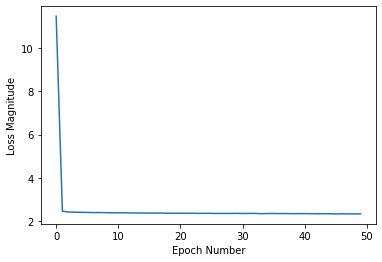

In [112]:
# #將Layer放入Model中
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=16,input_shape=[X_dropped.shape[1]]),
    tf.keras.layers.Dense(units=16, kernel_initializer='random_uniform', activation='relu'),
    tf.keras.layers.Dense(units=16, kernel_initializer='random_uniform', activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Dense(units=32),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)

    ])
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(units=50,input_shape=[X_dropped.shape[1]]),
#     tf.keras.layers.Dense(units=50, kernel_initializer='random_uniform', activation='relu'),
#     tf.keras.layers.Dense(units=50, kernel_initializer='random_uniform', activation='relu'),
#     # tf.keras.layers.Dropout(0.2),
#     # tf.keras.layers.Dense(units=32),
#     # tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(units=1)

#     ])


# model = tf.keras.Sequential()  
# # 輸入層
# #model.add(Dense(units=3, input_dim=1, kernel_initializer='uniform', activation='relu'))
# model.add(tf.keras.layers.Dense(units=10, input_dim=9, kernel_initializer='uniform', activation='relu'))
# model.add(tf.keras.layers.Dropout(0.2))

# # 隱藏層
# #model.add(Dense(units=5, kernel_initializer='uniform', activation='relu'))
# model.add(tf.keras.layers.Dense(units=20, kernel_initializer='uniform', activation='relu'))
# model.add(tf.keras.layers.Dense(units=30, kernel_initializer='uniform', activation='relu'))
# model.add(tf.keras.layers.Dense(units=40, kernel_initializer='uniform', activation='relu', kernel_regularizer='l2'))
# model.add(tf.keras.layers.Dropout(0.2))

# # 輸出層
# #model.add(tf.keras.layers.Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
# model.add(tf.keras.layers.Dense(units=1)) #如果我們再做二元分類，輸出層就要使用sigmoid
#==============================================================================================
#print("\n[Info] Show model summary...")  
model.summary()
print("\n[Info] 訓練中...")  
# 定義 tensorboard callback
tensorboard_callback = [tf.keras.callbacks.TensorBoard(log_dir='D:/Projects/AI/POC/homework/logs')]
#======================================================================================
#compile()方法來指定損失函數與優化函數，也可以額外指定一系列的訓練和評估期間計算評量標準
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  
#root_mean_squared_error
from tensorflow.keras import backend as K 
def root_mean_squared_error(y_true, y_pred): 
     return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 
# model.compile(optimizer = "rmsprop", loss = root_mean_squared_error,metrics =["accuracy"],callbacks=tensorboard_callback) 
model.compile(optimizer = "adam", loss = root_mean_squared_error,metrics =["accuracy"],callbacks=tensorboard_callback) 
#-----------------------------------
#mean_squared_error
#model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01), metrics=['accuracy'], callbacks=tensorboard_callback) 
#======================================================================================
 
# train_history = model.fit(x=X_dropped, y=Y_dropped,
#                validation_data=(X_dropped_test, Y_dropped_test), # Use this instead
#                 epochs=50, batch_size=30, verbose=2) #validation_split=0.1, 用最後的10%資料驗證 batch_size=200: 每一批次200筆資料 verbose=2: 顯示訓練過程
train_history = model.fit(x=X_dropped, y=Y_dropped,
               #validation_data=(X_dropped_test, Y_dropped_test), # Use this instead
               validation_split=0.20, epochs=50, batch_size=32, verbose=2) #validation_split=0.1, 用最後的10%資料驗證 batch_size=200: 每一批次200筆資料
# early_stopping = tf.keras.callbacks.EarlyStopping(patience=25)
# train_history = model.fit(x=X_dropped, y=Y_dropped, validation_split=0.1, epochs=200, batch_size=30, verbose=2)
# train_history = model.fit(X_dropped, Y_dropped, epochs=20, verbose=True)
print("Finished training the model")
model.save(save_model)

plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.plot(train_history.history['loss'])
plt.show()

[ 0  0  0  0  3  1  0  2  3  0  2  1  0  2  2  0  2  0  2  0  0  0  2  2
  1  5  5  2  4  5  0  5  2  3  2  2  2  0  4  5  1  1  3  1  2  0  4  3
  4  1  2  4  0  6  2  2  1  4  2  4  1  1  8  4  4  6  3  3  6  3  3  3
  3  3  7  8  4  4  4  7  8  7  5 17  8  8  6  9  9  5 10  7  8  6  4  7
  7 18  4  8  4  7  7  9 14  7  6  4  9  4 17  8 14 13  7 17  9  9  9 15
  9  9  9  6  8  8  9 10  6  9  6  7 13  7 13 13 13  9 17 18  7 11  5 17
 17 10  8 13 14 11 10 17 17 26 19 17 22 20 10 21 13 17 17 22 20 22 25 22
 20 20 20 22 20 20 20 22 31 20 32 20 29 33 32 26 22 20 20 25 33 33 28 33
 28 27 33 25 23 25 25 27 25 30 33 32 26 33 33 29 27 27 29 29 33 33 33 11
 11 29 26 33 11 34 34 29 36 34 27 34 34 43 37 30 33 37 33 37 43 35 29 28
 28 33 28 11 42 32 32 32 32 33 32 33 43 33 33 33 36 44 34 30 44 44 37 37
 33 37 37 33 34 37 31 36 32 32 32 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 35 36 36 15 38 38 37 47 43 34 37 37 29 29 37 37 51 36 57]


4.584335178873602

In [114]:
lin_mse

21.016129032258064

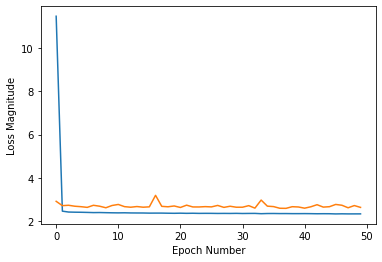

In [117]:
plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.plot(train_history.history['loss'], label = 'loss')

#plt.show()
#plt.ylabel("accuracy")
plt.plot(train_history.history['val_loss'], label = 'accuracy')# 準確度

plt.show()

In [118]:
#import matplotlib.pyplot as plt

def acc_draw(hist):
    plt.plot(hist.history['accuracy'], label = 'train')
    plt.plot(hist.history['val_accuracy'], label = 'validation')
    plt.title("train acc vs validation acc")
    plt.xlabel("Epochs")
    plt.ylabel("acc")
    plt.legend()
    plt.show()
def loss_draw(hist):
    plt.style.use('ggplot')
    plt.plot(hist.history['loss'], label = 'train')
    plt.plot(hist.history['val_loss'], label='validation')
    plt.title("train loss vs validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
 

In [119]:
#model.predict(X_dropped_test)

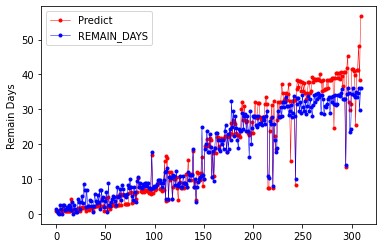

In [120]:
# df_test3.info()
#model = tf.keras.models.load_model(save_model)
# print(model.predict(df_test3))

# plt.xlabel('Seq Number')
plt.ylabel("Remain Days")

plt.plot(model.predict(X_dropped_test), label = "Predict", color='red', marker='.',linewidth = '0.5')
plt.plot(Y_dropped_test, label = "REMAIN_DAYS", color='blue', marker='.',linewidth = '0.5')
plt.legend()
plt.show()

In [121]:
y_predict = model.predict(X_dropped_test)

df2_test['predict'] = y_predict
df_test['predict'] = y_predict

In [122]:
df2_test
df_test['predict'] = y_predict
df_test

,DATA_DATE,IDX,LOT_ID,STATUS,CHIPNAME,LAYER,REMAIN_LAYER_SEQ,OP_NO,REMAIN_OP_SEQ,PRIORITY,...,WL,WS,WT,ZL,ACTUAL_WP_OUT,PROCESSED_DAYS,CYCLE_TIME,REMAIN_DAYS,LAYER_REMAIN_DAYS,predict
402,2020-12-20 07:30:00,535158,AWP609000,WAITING,CHIP266,PV,1.0,PV.CQC20,18.0,4,...,NaN,NaN,NaN,NaN,2020-12-21 18:12:00,64.227083,65.672917,1.445833,2.24,0.776099
403,2020-12-20 07:30:00,535159,AWP610000,PROCESSING,CHIP266,PV,1.0,PV.EEA10,8.0,4,...,NaN,NaN,NaN,NaN,2020-12-21 04:22:00,64.225694,65.095139,0.869444,2.24,0.775954
404,2020-12-20 07:30:00,535093,AWP535000,WAITING,CHIP266,PV,1.0,PV.FFL10,2.0,4,...,NaN,NaN,NaN,NaN,2020-12-20 13:52:00,65.308333,65.573611,0.265278,2.24,0.776159
405,2020-12-20 07:30:00,535018,AWP468000,PROCESSING,CHIP266,PV,1.0,PV.FFL10,2.0,4,...,NaN,NaN,NaN,NaN,2020-12-20 09:23:00,66.272917,66.351389,0.078472,2.24,0.775954
406,2020-12-20 07:30:00,535434,AWP864000,PROCESSING,CHIP266,5M,2.0,5M.EEM10,29.0,4,...,NaN,NaN,NaN,NaN,2020-12-22 21:07:00,60.220139,62.787500,2.567361,5.12,1.059239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,2020-12-20 07:30:00,538130,AWT311000,PROCESSING,CHIP266,2P,15.0,2P.WWM10,339.0,4,...,NaN,NaN,NaN,NaN,2021-01-22 22:03:00,24.242361,57.848611,33.606250,37.25,41.219162
777,2020-12-20 07:30:00,538131,AWT312000,WAITING,CHIP266,6P,14.0,6P.PQX20,336.0,4,...,NaN,NaN,NaN,NaN,2021-01-24 00:46:00,24.242361,58.961806,34.719444,36.07,41.186821
778,2020-12-20 07:30:00,538740,AWT867000,PROCESSING,CHIP266,1N,20.0,1N.PPK10,410.0,4,...,NaN,NaN,NaN,NaN,2021-01-25 13:05:00,16.236806,52.469444,36.232639,43.76,48.277885
779,2020-12-20 07:30:00,539083,AXA190000,PROCESSING,CHIP266,6N,22.0,6N.IIB10,434.0,1,...,NaN,NaN,NaN,NaN,2021-01-19 00:37:00,11.283333,40.996528,29.713194,47.81,38.409176


In [123]:
#df2_test['diff'] = (df2_test['predict'] - df2_test['REMAIN_DAYS']).abs().astype(int) 
df2_test['diff'] =abs(df2_test['REMAIN_DAYS'].apply(np.floor)-df2_test['predict'].apply(np.floor))

#sector = df2_test.groupby("diff")
sector=df2_test.groupby(['diff']).agg(count_col=pd.NamedAgg(column="PRIORITY", aggfunc="count"))

#.cumsum()

percetage = pd.DataFrame({'Percentage': df2_test.groupby(('diff')).size() / len(df2_test)})


In [124]:
df2_test

,STATUS,LAYER,REMAIN_LAYER_SEQ,REMAIN_OP_SEQ,PRIORITY,WIP_QTY,IS_MAIN_ROUTE,PROCESSED_DAYS,REMAIN_DAYS,LAYER_REMAIN_DAYS,predict,diff
402,WAITING,PV,1.0,18.0,4,25,1,64.227083,1.445833,2.24,0.776099,1.0
403,PROCESSING,PV,1.0,8.0,4,25,1,64.225694,0.869444,2.24,0.775954,0.0
404,WAITING,PV,1.0,2.0,4,25,1,65.308333,0.265278,2.24,0.776159,0.0
405,PROCESSING,PV,1.0,2.0,4,25,1,66.272917,0.078472,2.24,0.775954,0.0
406,PROCESSING,5M,2.0,29.0,4,25,1,60.220139,2.567361,5.12,1.059239,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
776,PROCESSING,2P,15.0,339.0,4,25,1,24.242361,33.606250,37.25,41.219162,8.0
777,WAITING,6P,14.0,336.0,4,25,1,24.242361,34.719444,36.07,41.186821,7.0
778,PROCESSING,1N,20.0,410.0,4,25,1,16.236806,36.232639,43.76,48.277885,12.0
779,PROCESSING,6N,22.0,434.0,1,25,1,11.283333,29.713194,47.81,38.409176,9.0


In [125]:
#result = pd.concat([df_test, df2_test], axis=1)

#df2_test['diff','predict']
# df2_test.groupby(["diff"])["CHIPNAME"].count()

# state_office = df.groupby(['state', 'office_id']).agg({'sales': 'sum'})
# state = df.groupby(['state']).agg({'sales': 'sum'})
# state_office.div(state, level='state') * 100

In [126]:
df2_test

,STATUS,LAYER,REMAIN_LAYER_SEQ,REMAIN_OP_SEQ,PRIORITY,WIP_QTY,IS_MAIN_ROUTE,PROCESSED_DAYS,REMAIN_DAYS,LAYER_REMAIN_DAYS,predict,diff
402,WAITING,PV,1.0,18.0,4,25,1,64.227083,1.445833,2.24,0.776099,1.0
403,PROCESSING,PV,1.0,8.0,4,25,1,64.225694,0.869444,2.24,0.775954,0.0
404,WAITING,PV,1.0,2.0,4,25,1,65.308333,0.265278,2.24,0.776159,0.0
405,PROCESSING,PV,1.0,2.0,4,25,1,66.272917,0.078472,2.24,0.775954,0.0
406,PROCESSING,5M,2.0,29.0,4,25,1,60.220139,2.567361,5.12,1.059239,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
776,PROCESSING,2P,15.0,339.0,4,25,1,24.242361,33.606250,37.25,41.219162,8.0
777,WAITING,6P,14.0,336.0,4,25,1,24.242361,34.719444,36.07,41.186821,7.0
778,PROCESSING,1N,20.0,410.0,4,25,1,16.236806,36.232639,43.76,48.277885,12.0
779,PROCESSING,6N,22.0,434.0,1,25,1,11.283333,29.713194,47.81,38.409176,9.0


In [127]:
#df2_test.describe


In [128]:
percetage

,Percentage
diff,
0.0,0.135484
1.0,0.241935
2.0,0.200000
3.0,0.119355
4.0,0.074194
5.0,0.070968
6.0,0.051613
7.0,0.038710
8.0,0.016129


In [129]:
percetage['Percentage'].cumsum()

diff
0.0     0.135484
1.0     0.377419
2.0     0.577419
3.0     0.696774
4.0     0.770968
5.0     0.841935
6.0     0.893548
7.0     0.932258
8.0     0.948387
9.0     0.983871
10.0    0.987097
11.0    0.990323
12.0    0.993548
16.0    0.996774
20.0    1.000000
Name: Percentage, dtype: float64

In [130]:
df_test[['REMAIN_DAYS','predict']].describe()

,REMAIN_DAYS,predict
count,310.000000,310.000000
mean,17.235423,18.206118
std,11.714860,14.236732
min,0.078472,0.775954
25%,7.252604,5.331190
50%,15.133681,16.118123
75%,28.712847,32.097153
max,36.232639,56.664715


<AxesSubplot:>

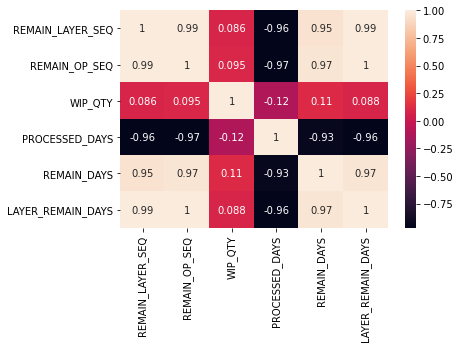

In [131]:
import seaborn as sns
Var_Corr = df2_test.drop(columns=['diff','predict']).corr()
# plot the heatmap and annotation on it
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)

In [ ]:
#試看看決策樹==============new
#sklearn預設的y的類型必須是整數型，你的y可能是float類型，你轉換一下應該就好了
 

from sklearn import tree
from sklearn import datasets
#import pydotplus #用來看樹怎麼做分類 conda install -c conda-forge pydotplus
clf=tree.DecisionTreeClassifier(criterion='entropy').fit(X_dropped, np.array(Y_dropped, dtype=int) )
clf.score(X_dropped,np.array(Y_dropped, dtype=int))  #output 1.0
#score = 0.95

ct_predictions = clf.predict(X_dropped_test) #entropy模型
clf.score(X_dropped_test, np.array(Y_dropped_test, dtype=int) ) #output(0.9)
print(ct_predictions)
#score = 0.15

# from sklearn.metrics import mean_squared_error
# lin_mse = mean_squared_error(np.array(Y_dropped_test, dtype=int),ct_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

In [ ]:
#試看看GridSearchCV==============new
#簡單的基本評估方式
from sklearn.model_selection import GridSearchCV

def get_best_model_and_accuracy(model,params,X,y):
    grid = GridSearchCV(model,params,error_score=0.)

    grid.fit(X, y)           # fit the model and parameters
    # our classical metric for performance
    print("Best Accuracy: {}".format(grid.best_score_))
    # the best parameters that caused the best accuracy
    print("Best Parameters: {}".format(grid.best_params_))
    # the average time it took a model to fit to the data (in seconds)
    print("Average Time to Fit (s): {}".format(round(grid.cv_results_['mean_fit_time'].mean(), 3)))
    # the average time it took a model to predict out of sample data (in seconds)
    # this metric gives us insight into how this model will perform in real-time analysis
    print("Average Time to Score (s): {}".format(round(grid.cv_results_['mean_score_time'].mean(), 3)))

model_param = {'validation_split':[0.20], 'epochs':[50], 'batch_size':[32], 'verbose':[2]}
#get_best_model_and_accuracy(model, model_param, X_dropped, Y_dropped)    
